# Model Inversion from prediction output



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## Define model architecture (CNN classifier)

In [2]:
torch.manual_seed(50)

device = "cpu"

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

n_classes = 10

class LeNet(nn.Module):
	def __init__(self):
		super(LeNet, self).__init__()
		act = nn.Sigmoid
		self.body = nn.Sequential(
			nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2),
			act(),
			nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
			act(),
			nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
			act(),
			nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
			act(),
		)
		self.fc = nn.Sequential(
			nn.Linear(768, n_classes),
		)
		
	def forward(self, x):
		out = self.body(x)
		out = out.view(out.size(0), -1)
		out = self.fc(out)
		return out

### define loss for one hot encoded labels

In [3]:
def cross_entropy_for_onehot(pred, target):
	return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [4]:
net = LeNet().to(device)
net.apply(weights_init)

criterion = cross_entropy_for_onehot
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Load datset (MNIST)

In [5]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
	torchvision.datasets.MNIST('/files/', train=True, download=True,
								transform=torchvision.transforms.Compose([
								torchvision.transforms.ToTensor(),
								torchvision.transforms.Normalize(
								(0.1307,), (0.3081,)),
								torchvision.transforms.Resize((32, 32))
								])),
	batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
	torchvision.datasets.MNIST('/files/', train=False, download=True,
								transform=torchvision.transforms.Compose([
								torchvision.transforms.ToTensor(),
								torchvision.transforms.Normalize(
									(0.1307,), (0.3081,)),
								torchvision.transforms.Resize((32, 32))
								])),
	batch_size=batch_size, shuffle=True)

## Train model

In [6]:
for epoch in range(10):  # loop over the dataset multiple times

	running_loss = 0.0
	for batch_idx, (data, target) in enumerate(train_loader):

		labels = torch.zeros((target.shape[0], 10), dtype=torch.float)
		for i, l in enumerate(target):
			labels[i][l] = 1.

		# zero the parameter gradients
		optimizer.zero_grad()
		# forward + backward + optimize
		outputs = net(data)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		# print statistics
		running_loss += loss.item()

	print("epoch %d loss: %.3f" % (epoch+1, running_loss / batch_size))

epoch 1 loss: 9.851
epoch 2 loss: 3.062
epoch 3 loss: 2.114
epoch 4 loss: 1.603
epoch 5 loss: 1.320
epoch 6 loss: 1.144
epoch 7 loss: 1.010
epoch 8 loss: 0.918
epoch 9 loss: 0.824
epoch 10 loss: 0.761


### test model

In [8]:
data, label = next(iter(test_loader))
for i in range(len(label)):
	pred = net(torch.unsqueeze(data[i], 0))
	print("expected label %d / model result %d" % (label[i], torch.argmax(pred)))

expected label 1 / model result 1
expected label 2 / model result 2
expected label 2 / model result 2
expected label 9 / model result 9
expected label 6 / model result 6
expected label 9 / model result 9
expected label 5 / model result 5
expected label 2 / model result 2
expected label 2 / model result 2
expected label 7 / model result 7
expected label 1 / model result 1
expected label 9 / model result 9
expected label 2 / model result 2
expected label 4 / model result 4
expected label 1 / model result 1
expected label 8 / model result 8
expected label 0 / model result 0
expected label 4 / model result 4
expected label 9 / model result 9
expected label 7 / model result 7
expected label 3 / model result 3
expected label 0 / model result 8
expected label 5 / model result 5
expected label 9 / model result 9
expected label 8 / model result 8
expected label 5 / model result 5
expected label 0 / model result 0
expected label 5 / model result 5
expected label 2 / model result 2
expected label

## Inversion attack

We train the attacker model with EMNIST to simulate the fact that we may not know the exact dataset user for target model's training

### Load EMNIST

In [61]:
batch_size = 64

attack_train_loader = torch.utils.data.DataLoader(
	torchvision.datasets.EMNIST('/files/', train=True, download=True, split="letters",
								transform=torchvision.transforms.Compose([
								torchvision.transforms.ToTensor(),
								torchvision.transforms.Normalize(
								(0.1307,), (0.3081,)),
								torchvision.transforms.Resize((32, 32))
								])),
	batch_size=batch_size, shuffle=True)

attack_test_loader = torch.utils.data.DataLoader(
	torchvision.datasets.EMNIST('/files/', train=False, download=True, split="letters",
								transform=torchvision.transforms.Compose([
								torchvision.transforms.ToTensor(),
								torchvision.transforms.Normalize(
									(0.1307,), (0.3081,)),
								torchvision.transforms.Resize((32, 32))
								])),
	batch_size=batch_size, shuffle=True)

In [62]:
# attacker is a reversed target's body (only conv2D)
class Attacker(nn.Module):
	def __init__(self):
		super().__init__()
		self.fc = nn.Sequential(
			nn.Linear(n_classes, 768),
		)
		self.body= nn.Sequential(
			nn.ConvTranspose2d(12, 12, kernel_size=7),
			nn.Sigmoid(),
			nn.ConvTranspose2d(12, 12, kernel_size=7),
			nn.Sigmoid(),
			nn.ConvTranspose2d(12, 12, kernel_size=7),
			nn.Sigmoid(),
			nn.ConvTranspose2d(12, 1, kernel_size=7),
		)

	def forward(self, x):
		out = self.fc(x)
		out = out.reshape((out.shape[0], 12, 8, 8))
		out = self.body(out)
		return out

In [64]:
attacker = Attacker()
criterion = nn.MSELoss()
optimiser = optim.Adam(attacker.parameters(), lr=1e-4)

# we will only update the attacker model
net.train(False)

#for epoch in range(10):
for data, labels in tqdm(attack_train_loader):
	for i in range(len(labels)):
		
		inputs = torch.unsqueeze(data[i], 0)

		# Reset gradients
		optimiser.zero_grad()

		# First, get outputs from the target model
		target_outputs = net(inputs)
		# Next, recreate the data with the attacker
		attack_outputs = attacker(target_outputs)
		# We want attack outputs to resemble the original data
		loss = criterion(attack_outputs, inputs)

		# Update the attack model
		loss.backward()
		optimiser.step()

  0%|          | 0/1950 [00:00<?, ?it/s]

## check

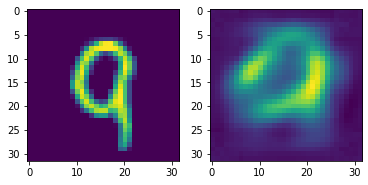

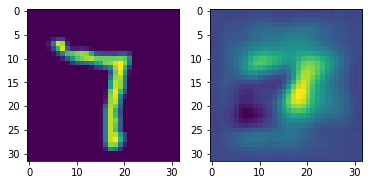

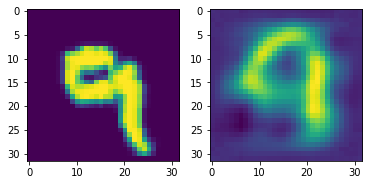

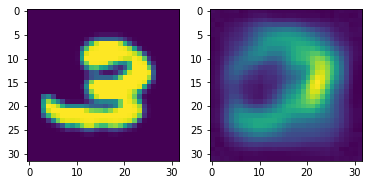

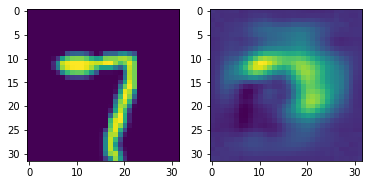

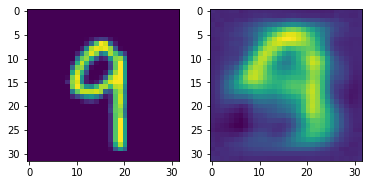

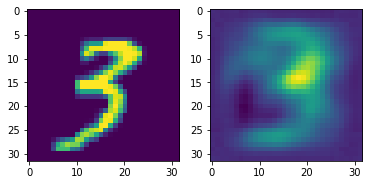

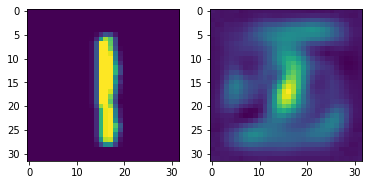

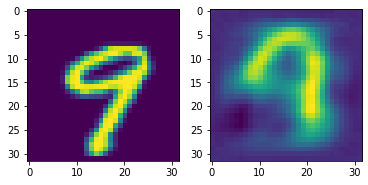

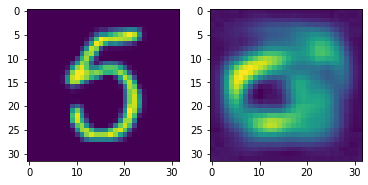

In [65]:
i = 0
for data, targets in test_loader:
	for i in range(len(targets)):
		target_outputs = net(torch.unsqueeze(data[i], 0))
		recreated_data = attacker(target_outputs)

		fig, axes = plt.subplots(1, 2)
		axes[0].imshow(data[i].detach().numpy()[0].reshape((32, 32, 1)))
		axes[1].imshow(recreated_data.detach().numpy()[0].reshape((32, 32, 1)))
		plt.show()
		i += 1
		if i == 10: break
	break